# DEMO: Model Building, Scoring & Evaluating (Logistic Regression)

## Imports

In [ ]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F

from snowflake.ml.modeling.linear_model import LogisticRegression
from snowflake.ml.modeling.metrics import *

import json
import pandas as pd
import seaborn as sns

## Create Snowpark Session

In [ ]:
with open('creds.json') as f:
    connection_parameters = json.load(f)

In [ ]:
session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

# Model Building

We will use the balanced data set we created in the last part.

In [ ]:
application_record_balanced_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED')
application_record_balanced_sdf.group_by('TARGET').count().show()

We are going to use stratified sampling of the data. Using **sample_by** allows us to sample based on one column and also specify the fractions of each value in the column.

In [ ]:
train_sdf = application_record_balanced_sdf.sample_by("TARGET", {1: 0.8, 0: 0.8})
train_sdf = train_sdf.cache_result()
train_sdf.group_by('TARGET').count().show()

The test data set is the rest of the rows, by using **minus** we can exclude the rows from the train_sdf DataFrame

In [ ]:
test_sdf = application_record_balanced_sdf.minus(train_sdf)
test_sdf.group_by('TARGET').count().show()

Save the training and test data into tables

In [ ]:
train_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TRAIN', mode='overwrite')
test_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TEST', mode='overwrite')

train_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN')
test_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TEST')

Fit a LogisticRegression model using snowpark-ml, the fitting is pushed down to Snowflake and is using scikit-learn behind the scene.

In [ ]:
feature_cols = train_sdf.columns
feature_cols.remove('TARGET')
feature_cols.remove('ID')
target_col = 'TARGET'

lm = LogisticRegression(
    C=0.8, 
    solver='lbfgs',
    random_state=0, 
    input_cols=feature_cols, 
    label_cols=target_col, 
    output_cols=['PREDICTION']
    )
lm.fit(train_sdf)

The fitted model can be retrieved as a scikit-learn object

In [ ]:
lm_local = lm.to_sklearn()
lm_local

Plot Feature Coefficients

In [ ]:
feature_coefficients = pd.DataFrame(lm_local.coef_.T,lm_local.feature_names_in_,columns=['Coefficient'])
feature_coefficients.sort_values('Coefficient').plot.barh(y='Coefficient', figsize=(5,15))

# Model Scoring

Using the predict method of the snowpark-ml model will push down the scoring into Snowflake, it can be applied on a Snowpark DataFrame or a Pandas DataFrame

In [ ]:
scored_snowml_sdf = lm.predict(test_sdf)
# Saving it as a table so we do not call the predict function when using the scored DataFrame
scored_snowml_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED', mode='overwrite')

# Model Evaluation

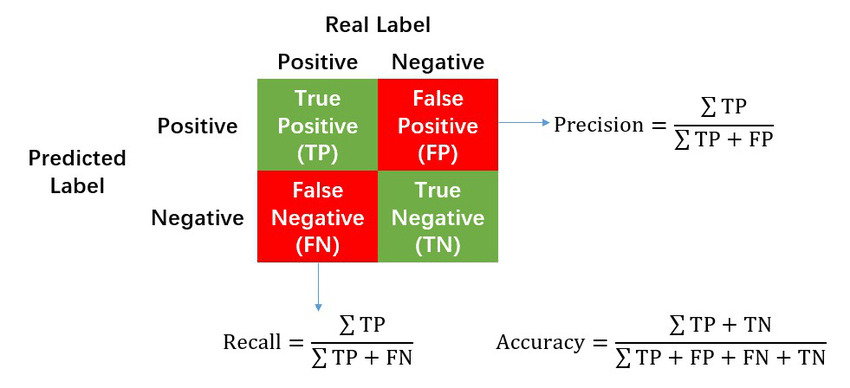

In [ ]:
scored_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED')

In [ ]:
# Obtaining and plotting a simple confusion matrix
cf_matrix = confusion_matrix(df=scored_sdf, y_true_col_name='TARGET', y_pred_col_name='PREDICTION')

sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

Calculate the Accuracy, Precision, Recall and F1 metrics

In [ ]:
print('Acccuracy:', accuracy_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('Precision:', precision_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('Recall:', recall_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('F1:', f1_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))

In [ ]:
session.close()